# 1. Подготовка данных

In [1]:
!pip install catboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
from catboost import Pool, CatBoost

In [2]:
pd.options.display.max_rows = 1000

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Чтение данных.

In [4]:
date_columns = ['DateCrawled', 'DateCreated', 'LastSeen']
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/autos.csv', parse_dates=date_columns)

### Переводим названия столбцов в нижний регистр.

In [5]:
df.columns = df.columns.str.lower()

### Удаляем дубликаты.

In [6]:
print(df.duplicated().sum())
df = df.drop_duplicates().reset_index(drop=True)
print(df.duplicated().sum())

4
0


### Ознакомление.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354365 entries, 0 to 354364
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   datecrawled        354365 non-null  datetime64[ns]
 1   price              354365 non-null  int64         
 2   vehicletype        316875 non-null  object        
 3   registrationyear   354365 non-null  int64         
 4   gearbox            334532 non-null  object        
 5   power              354365 non-null  int64         
 6   model              334660 non-null  object        
 7   kilometer          354365 non-null  int64         
 8   registrationmonth  354365 non-null  int64         
 9   fueltype           321470 non-null  object        
 10  brand              354365 non-null  object        
 11  notrepaired        283211 non-null  object        
 12  datecreated        354365 non-null  datetime64[ns]
 13  numberofpictures   354365 non-null  int64   

##### Имеются пропущенные значения.

In [8]:
df.isna().sum()

datecrawled              0
price                    0
vehicletype          37490
registrationyear         0
gearbox              19833
power                    0
model                19705
kilometer                0
registrationmonth        0
fueltype             32895
brand                    0
notrepaired          71154
datecreated              0
numberofpictures         0
postalcode               0
lastseen                 0
dtype: int64

### Пропущенные значения notrepaired заполним типом no_info.

In [9]:
df['notrepaired'] = df['notrepaired'].fillna('unknown')

##### Пропущенные значения обработаны.

### Проверка на выбросы registrationyear.

In [10]:
print(df['registrationyear'].describe())

count    354365.000000
mean       2004.234481
std          90.228466
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registrationyear, dtype: float64


In [11]:
df['registrationyear'].value_counts().sort_index()

1000       37
1001        1
1039        1
1111        3
1200        1
1234        4
1253        1
1255        1
1300        2
1400        1
1500        5
1600        2
1602        1
1688        1
1800        5
1910      101
1915        1
1919        1
1920        1
1923        2
1925        1
1927        1
1928        2
1929        7
1930        3
1931        1
1932        3
1933        3
1934        3
1935        4
1936        3
1937       11
1938        8
1940        2
1941        2
1942        3
1943        4
1944        2
1945        4
1946        1
1947        2
1948        3
1949        1
1950       18
1951       12
1952        9
1953       14
1954       11
1955       15
1956       27
1957       13
1958       25
1959       32
1960      188
1961       41
1962       46
1963       57
1964       64
1965       82
1966      113
1967       99
1968      108
1969      118
1970      333
1971      167
1972      213
1973      173
1974      169
1975      143
1976      175
1977      173
1978  

##### Видим большое количество аномальных значений.

### Проверим распределение дат создания объявлений - datecreated.

In [12]:
df['datecreated'].value_counts().sort_index()

2014-03-10        1
2015-03-20        1
2015-06-18        1
2015-08-07        1
2015-08-10        1
2015-09-04        2
2015-09-09        1
2015-11-02        1
2015-11-08        1
2015-11-10        1
2015-11-12        1
2015-11-17        1
2015-11-23        2
2015-11-24        2
2015-12-05        3
2015-12-06        1
2015-12-17        1
2015-12-27        1
2015-12-30        3
2016-01-02        4
2016-01-03        1
2016-01-06        1
2016-01-07        3
2016-01-08        1
2016-01-10        4
2016-01-13        3
2016-01-15        1
2016-01-16        1
2016-01-17        3
2016-01-18        1
2016-01-19        3
2016-01-20        2
2016-01-22        2
2016-01-23        3
2016-01-24        2
2016-01-25        4
2016-01-26        3
2016-01-27        4
2016-01-28        6
2016-01-29        5
2016-01-30        6
2016-01-31        7
2016-02-01        3
2016-02-02       13
2016-02-03        4
2016-02-04        2
2016-02-05        7
2016-02-06        3
2016-02-07        6
2016-02-08        2


##### Самая поздняя дата создания объявления - 04.2016. Все даты регистрации автомобиля позднее 04.2016 ошибочны, т.к. дата регистрации автомобиля не модет быть позже даты создания объявления. Удалим все строки с датой регистрации автомобиля позднее 04.2016 и ранее 1980 года.

In [13]:
df = df[(df['registrationyear']>=1980)&(df['registrationyear']<2017)]
df.drop(df[(df['registrationyear']==2016)&(df['registrationmonth']>4)].index, inplace=True)

(array([1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990,
        1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
        2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
        2013, 2014, 2015, 2016]), <a list of 37 Text major ticklabel objects>)

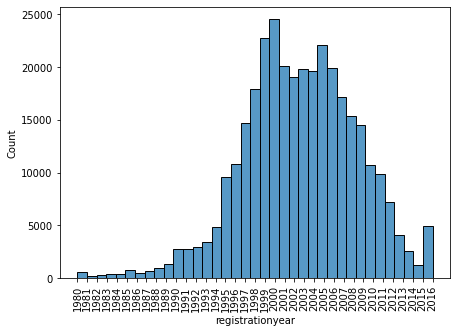

In [14]:
f, ax = plt.subplots(figsize=(7, 5))
sns.histplot(data=df, x='registrationyear', bins=37)
ax.set_xticks([1980+i for i in range(0,37)])
plt.xticks(rotation=90)

### Ознакомимся с распределением цен.

In [15]:
df['price'].describe()

count    331693.000000
mean       4476.674051
std        4537.810548
min           0.000000
25%        1100.000000
50%        2800.000000
75%        6500.000000
max       20000.000000
Name: price, dtype: float64

(array([-2500.,     0.,  2500.,  5000.,  7500., 10000., 12500., 15000.,
        17500., 20000., 22500.]), <a list of 11 Text major ticklabel objects>)

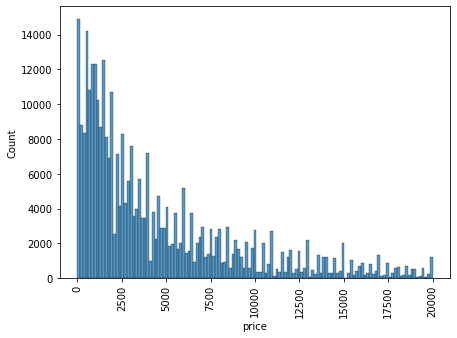

In [16]:
f, ax = plt.subplots(figsize=(7, 5))
sns.histplot(data=df, x='price')
#ax.set_xticks([1980+i for i in range(0,37)])
plt.xticks(rotation=90)

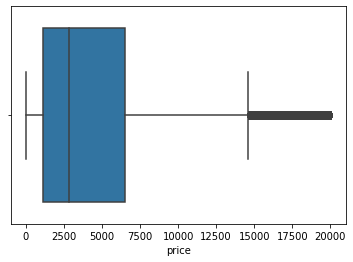

In [17]:
ax = sns.boxplot(x=df['price'])

##### Есть много низких значений цены, в том числе 0. Удаляем все автомобили, дешевле 100$ как выбросы. Есть очень дорогие автомобили, думаю их оставить.

In [18]:
df = df[df['price']>=1]
df = df[df['price']<=15000]

### Посмотрим на мощность автомобилей.

In [19]:
print(df['power'].describe())

count    307942.000000
mean        109.313585
std         182.031962
min           0.000000
25%          69.000000
50%         103.000000
75%         140.000000
max       20000.000000
Name: power, dtype: float64


##### Есть нулевые и аномально-высокие показатели мощности. Удалю все, что больше 1500.

In [20]:
pd.set_option('display.max_columns', 500) 

In [21]:
df = df[df['power']<=1500]

### Заполню нулевые значения мощности по медиане, если это возможно

In [22]:
df[df['power']==0]['model'].count()

26632

In [23]:
models = pd.Series(df[df['power']<1]['model'].unique())
for model in models:
    try:
      medians = int(df[(df['model']==model)&(df['power']>=1)]['power'].median())
      df.loc[((df['model']==model)&(df['power']<1)),'power'] = medians
    except:
      0
del models

In [24]:
#df = df[df['power']>=1]

In [25]:
df[df['power']==0]['model'].count()

0

### Пробег.

In [26]:
df['kilometer'].value_counts().sort_index(ascending=False)

150000    212147
125000     32156
100000     12570
90000       9834
80000       8358
70000       7018
60000       5956
50000       4805
40000       3735
30000       3295
20000       2853
10000        745
5000        4305
Name: kilometer, dtype: int64

##### В значениях пробега аномалий не выявлено. Странно, что всё кратно 5000, видимо, это округление.

### Создание новых признаков.

##### Время продажи.

In [27]:
df['saletime'] = round((pd.to_datetime(df['lastseen']) - pd.to_datetime(df['datecreated']))/np.timedelta64(1,'D'),0).astype('int')

### Удаляем пропущенные значения.

In [28]:
df = df.dropna()

### Масштабирование признаков.

In [29]:
cols = ['power', 'kilometer', 'postalcode','saletime']
scaler = StandardScaler()
df[cols] = scaler.fit_transform(df[cols])

### Разбиение на features и target и удаление ненужных столбцов.

In [30]:
df = df.reset_index(drop=True)
target = df['price']
features = df.drop(['price','datecrawled','datecreated','lastseen','numberofpictures','postalcode','registrationmonth'], axis=1)

# 2. Обучение моделей и подбор гиперпараметров.

### LightGBM.

##### Подгтовка данных.

In [31]:
encoder = OrdinalEncoder()
cols = ['registrationyear','model','brand','gearbox','fueltype','vehicletype','notrepaired']
df_ordinal = features.copy()
df_ordinal[cols] = pd.DataFrame(encoder.fit_transform(features[cols]), columns=cols, index=features.index)
#del xgbfeatures_train, xgbfeatures_valid, xgbfeatures_test

##### Разбиение на train, valid и test выборки.

In [32]:
gbmx_train, gbmx_split, gbmy_train, gbmy_split = train_test_split(
    df_ordinal, target, test_size=0.4, random_state=12345)
gbmx_valid, gbmx_test, gbmy_valid, gbmy_test = train_test_split(
    gbmx_split, gbmy_split, test_size=0.5, random_state=12345)
del gbmx_split, gbmy_split, df_ordinal

##### Проверка размеров выборок.

In [33]:
print(gbmx_train.shape)
print(gbmy_train.shape)
print(gbmx_valid.shape)
print(gbmy_valid.shape)
print(gbmx_test.shape)
print(gbmy_test.shape)

(158097, 10)
(158097,)
(52699, 10)
(52699,)
(52700, 10)
(52700,)


##### Обучение.

In [34]:
#num_leaves = [40,50,60,70,80]
#min_child_samples=[10,20,30,40,50]
#max_depth =[30,50,100,150,200]

In [35]:
#%%time
#acc = pd.DataFrame(columns = ['num_leaves','max_depth','min_child_samples','RMSE'])
#counter = 0
#for i in max_depth:
#    for j in min_child_samples:
#        for k in num_leaves:
#            gbm = lgb.LGBMRegressor(max_depth=i,min_child_samples=j,num_leaves=k,random_state=12345, n_jobs=-1).fit(gbmx_train, gbmy_train)
#            answers_gbm = gbm.predict(gbmx_valid, num_iteration=gbm.best_iteration_)
#            rmse_gbm = mean_squared_error(gbmy_valid, answers_gbm)**0.5
#            acc = acc.append({'num_leaves':k,'max_depth':i, 'min_child_samples':j,'RMSE':round(rmse_gbm,5)}, ignore_index=True)
#            print(counter)
#            counter += 1
#print(acc.sort_values('RMSE', ascending=True))

#### Визуализация важности признаков.

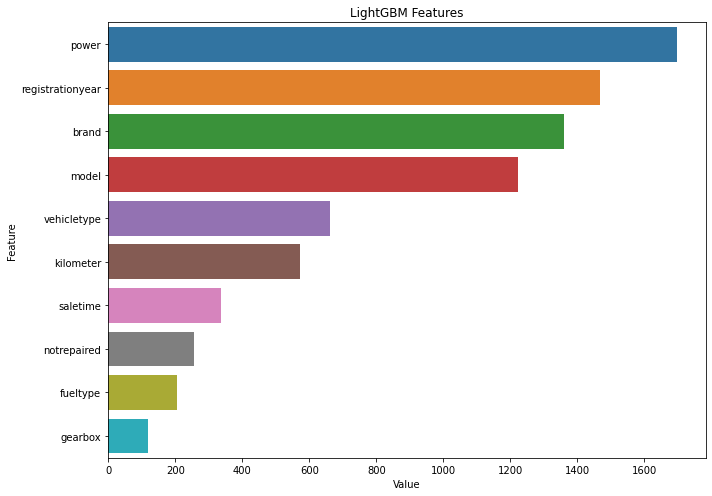

In [36]:
gbm = lgb.LGBMRegressor(max_depth=50,min_child_samples=20,num_leaves=80,random_state=12345, n_jobs=-1).fit(gbmx_train, gbmy_train)
feature_imp = pd.DataFrame(sorted(zip(gbm.feature_importances_,gbmx_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(10, 7))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()
#plt.savefig('lgbm_importances-01.png')

##### Лучший результат: LGBMRegressor(max_depth=50,min_child_samples=20,num_leaves=80)

### Catboost.

In [37]:
x_train, x_split, y_train, y_split = train_test_split(
    features, target, test_size=0.4, random_state=12345)
x_valid, x_test, y_valid, y_test = train_test_split(
    x_split, y_split, test_size=0.5, random_state=12345)
del x_split, y_split

In [38]:
iterations = [3000,4000]
depth = [14,15]
#cat_features = ['vehicletype','gearbox','model','fueltype','brand','notrepaired','yearcreated']

In [39]:
#%%time
#acc = pd.DataFrame(columns = ['depth','iterations','RMSE'])
#counter = 0
#for i in iterations:
#    for j in depth:
#        cbr = CatBoostRegressor(iterations=i, depth=j, random_state=12345,loss_function='RMSE', verbose=500,task_type='GPU').fit(gbmx_train, gbmy_train)
#        answers_cbr = cbr.predict(gbmx_valid)
#        rmse_cbr = mean_squared_error(gbmy_valid, answers_cbr)**0.5
#        acc = acc.append({'iterations':i, 'depth':j,'RMSE':round(rmse_cbr,5)}, ignore_index=True)
#        print(counter)
#        counter += 1
#print(acc.sort_values('RMSE', ascending=True))

##### Лучший результат: CatBoostRegressor(iterations=3000, depth=14)

### Визуализация важности признаков.

In [40]:
cbr = CatBoostRegressor(iterations=500, depth=15, random_state=12345,loss_function='RMSE', verbose=500,task_type='GPU').fit(gbmx_train, gbmy_train)

Learning rate set to 0.127236
0:	learn: 3384.2255786	total: 220ms	remaining: 1m 49s
499:	learn: 1022.8771873	total: 25.5s	remaining: 0us


In [41]:
features = pd.DataFrame(columns=['name','importance'])
features['importance'] = cbr.get_feature_importance()
features['name'] = gbmx_train.columns
features = features.sort_values('importance',ascending=False)

Text(0, 0.5, 'Feature importance')

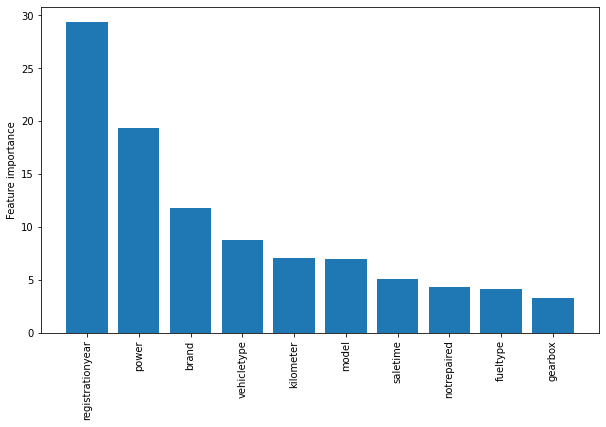

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.bar(x=np.arange(len(features)), height=features['importance'])
ax.set_xticklabels(features['name'], rotation=90)
ax.set_xticks(np.arange(len(features)))
ax.set_ylabel('Feature importance')

### Результаты:
2. LightGBM RMSE = 1549.21 
3. Catboost RMSE = 1589.65

Проверим на тестовой выборке.

# 3. Анализ моделей

### Предсказание по медианному и среднему значению target_test.

In [43]:
print('По медиане:',mean_squared_error(gbmy_test, ([gbmy_test.median()]*len(gbmy_test)))**0.5)
print('По среднему:',mean_squared_error(gbmy_test, ([gbmy_test.mean()]*len(gbmy_test)))**0.5)

По медиане: 3919.302630766984
По среднему: 3708.8885566540393


### Обучение выбранных моделей на тренировочных выборках.

#### LightGBM.

In [44]:
%%time
lgbm = lgb.LGBMRegressor(max_depth=50,min_child_samples=20,num_leaves=80,random_state=12345, n_jobs=-1).fit(gbmx_train, gbmy_train)
answers_gbm = lgbm.predict(gbmx_test, num_iteration=lgbm.best_iteration_)
rmse_gbm = mean_squared_error(gbmy_test, answers_gbm)**0.5
print('LightGBM RMSE на тестовой выборке:', rmse_gbm)

LightGBM RMSE на тестовой выборке: 1298.874462054607
CPU times: user 3.05 s, sys: 46.4 ms, total: 3.09 s
Wall time: 1.6 s


#### CatBoost.

In [45]:
%%time
cbr = CatBoostRegressor(depth=15,iterations=3500, random_state=12345,loss_function='RMSE', verbose=500, task_type='GPU').fit(pd.concat([gbmx_train,gbmx_valid]), pd.concat([gbmy_train,gbmy_valid]), use_best_model=True, eval_set=(gbmx_test,gbmy_test))
answers_cbr = cbr.predict(gbmx_test)
rmse_cbr = mean_squared_error(gbmy_test, answers_cbr)**0.5
print('Catboost RMSE на тестовой выборке:', rmse_cbr)

Learning rate set to 0.052956
0:	learn: 3579.3843950	test: 3564.5009498	best: 3564.5009498 (0)	total: 200ms	remaining: 11m 38s
500:	learn: 1173.6513385	test: 1333.2081773	best: 1333.1497034 (499)	total: 25.8s	remaining: 2m 34s
1000:	learn: 1089.0278987	test: 1329.4634711	best: 1327.3087486 (769)	total: 52.4s	remaining: 2m 10s
1500:	learn: 1069.8253460	test: 1332.1222320	best: 1327.3087486 (769)	total: 1m 19s	remaining: 1m 45s
2000:	learn: 1064.1715955	test: 1331.6446491	best: 1327.3087486 (769)	total: 1m 46s	remaining: 1m 19s
2500:	learn: 1016.1113241	test: 1333.4260763	best: 1327.3087486 (769)	total: 2m 13s	remaining: 53.2s
3000:	learn: 1001.6079995	test: 1336.6451183	best: 1327.3087486 (769)	total: 2m 40s	remaining: 26.6s
3499:	learn: 996.3672927	test: 1338.3887636	best: 1327.3087486 (769)	total: 3m 6s	remaining: 0us
bestTest = 1327.308749
bestIteration = 769
Shrink model to first 770 iterations.
Catboost RMSE на тестовой выборке: 1327.3088014570908
CPU times: user 2min 23s, sys: 2mi

### Показатели на тестовой выборке:
1. LightGBM RMSE на тестовой выборке: 1298.87
2. Catboost RMSE на тестовой выборке: 1327.31
3. По медиане RMSE: 3919.302630766984
4. По среднему RMSE: 3708.8885566540393